## ML Model for Generator Bearing Temperature

### Feature selection via importances and correaltion

* Author: Sergio Díaz
* Date: November 2017

In [12]:
%matplotlib notebook

In [13]:
import os
import math
import numpy as np
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [14]:
args =    {'target': 'WGENBearNDETemp'  ,  #  Target feature for modeling
            'target_time_series':       0, # y_pred vs y_test on 5 months SCADA (time series)  
            'scatter_feature_target':   1, # ML predicted pwr_curve
            'minutal_frequency':       10  # sampling frequency 
          }

In [15]:
# ********************************************READ HISTORICAL SCADA 
df_hist = read_historical_scada(args)

<IPython.core.display.Javascript object>


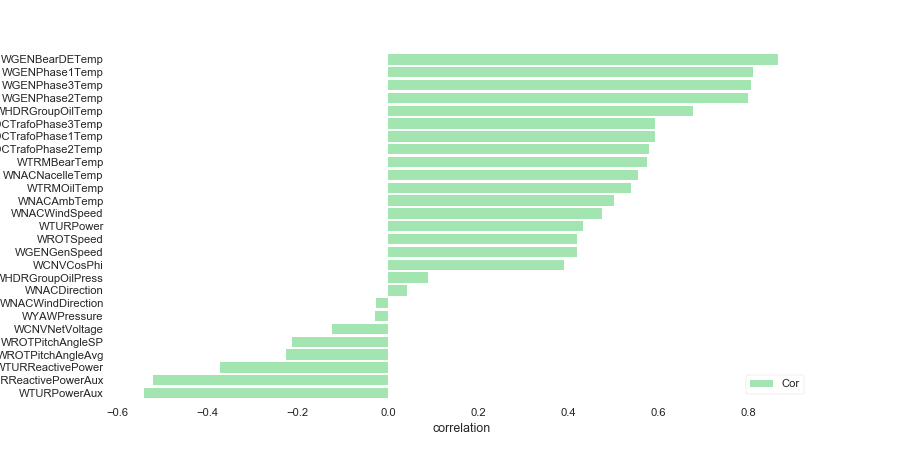

<IPython.core.display.Javascript object>


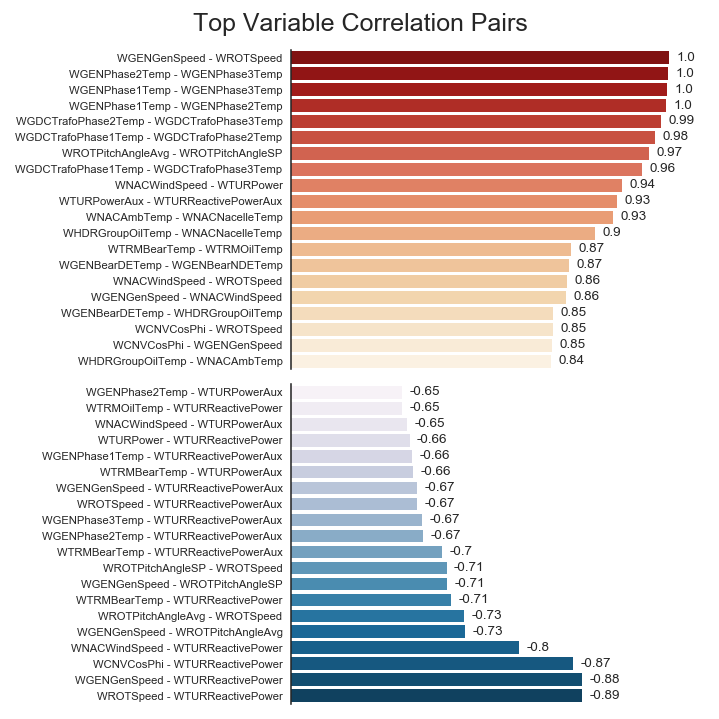

In [56]:
# ******************************************** DATA Exploration
correl(df_hist, args)
# distributions(df_hist)
# correlation_matrix(df_hist)
top_correlations(df_hist)

In [57]:
# ********************************************** FEATURE SELECTION
univariate_select(df_hist, args) # Feature Extraction with Univariate Statistical Tests

rfe(df_hist, args)               # Recursive feature extraction

Results:
                      scores
WGENPhase1Temp          0.71
WHDRGroupOilTemp        0.43
WGDCTrafoPhase1Temp     0.36
WNACNacelleTemp         0.32
WTURPowerAux            0.27
WTRMBearTemp            0.27
WTRMOilTemp             0.25
WTURReactivePowerAux    0.21
WTURPower               0.16
WROTSpeed               0.15
WGENGenSpeed            0.15
WCNVCosPhi              0.15
WTURReactivePower       0.13
WROTPitchAngleAvg       0.12
WNACDirection           0.11
WHDRGroupOilPress       0.09
WNACWindDirection       0.05
WYAWPressure            0.04
WCNVNetVoltage          0.03
Results:
                      importances  ranking  support
WGENPhase1Temp           7.15e-01        1     True
WHDRGroupOilTemp         2.05e-01        1     True
WNACNacelleTemp          2.66e-02        1     True
WGDCTrafoPhase1Temp      2.58e-02        1     True
WTRMBearTemp             6.16e-03        1     True
WTRMOilTemp              3.67e-03        4    False
WTURReactivePowerAux     3.08e-03     

Machine Learing model score wiht historical scada


<IPython.core.display.Javascript object>


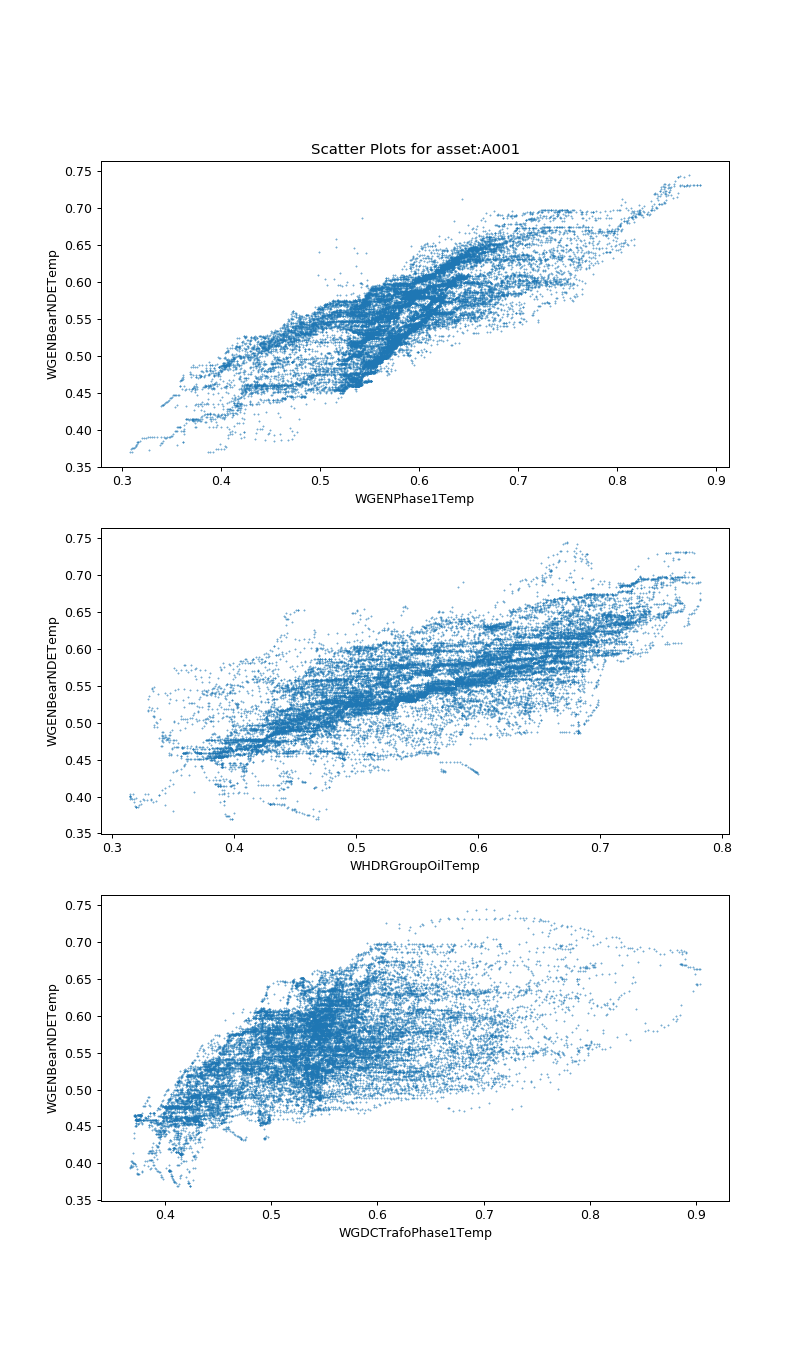

<IPython.core.display.Javascript object>


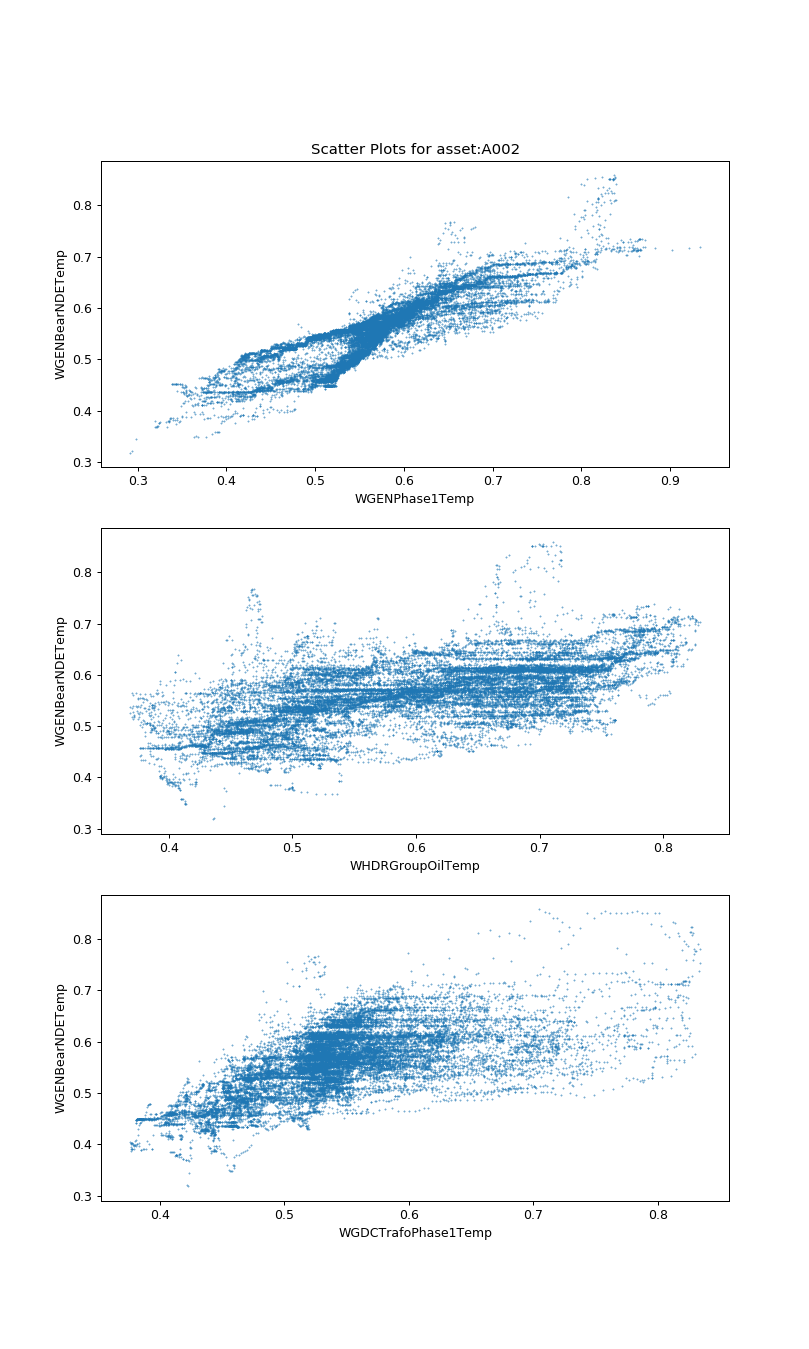

<IPython.core.display.Javascript object>


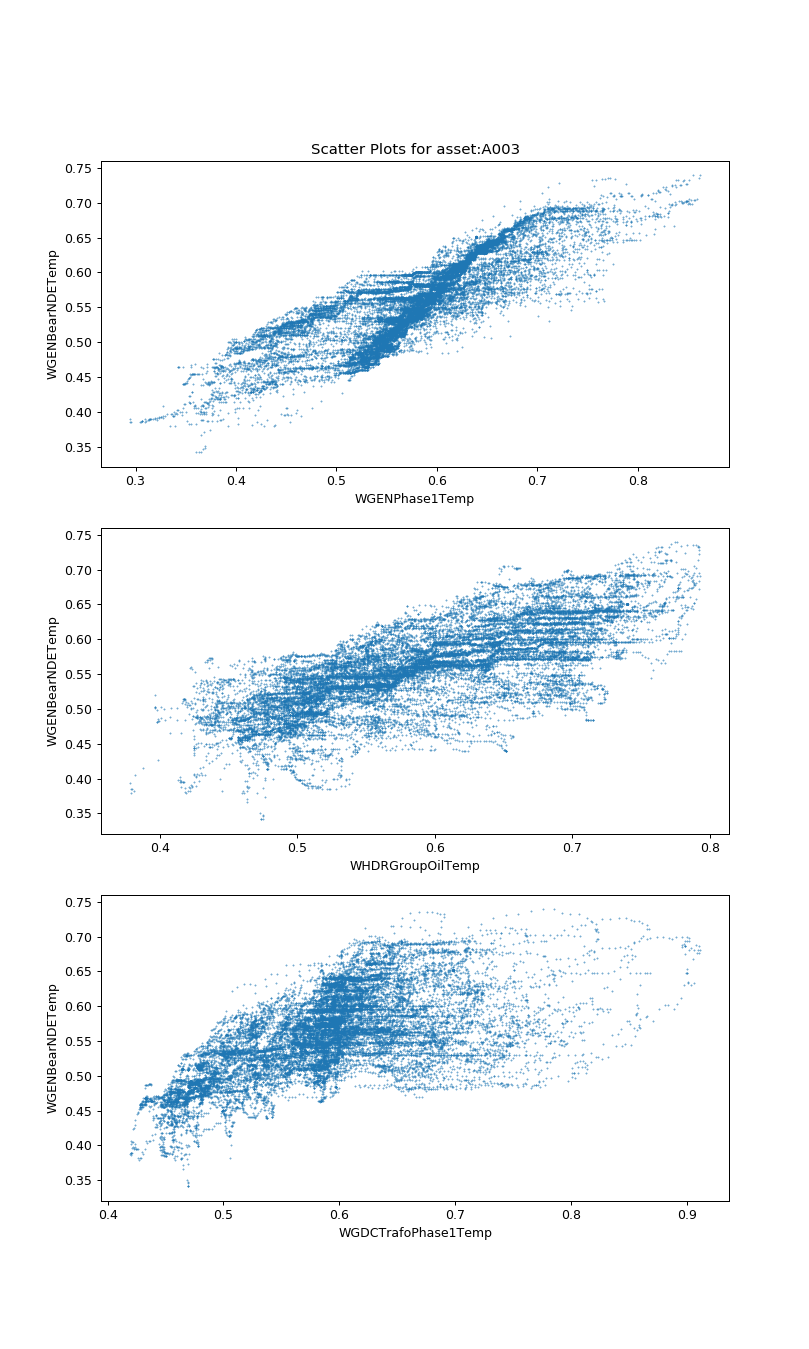

<IPython.core.display.Javascript object>


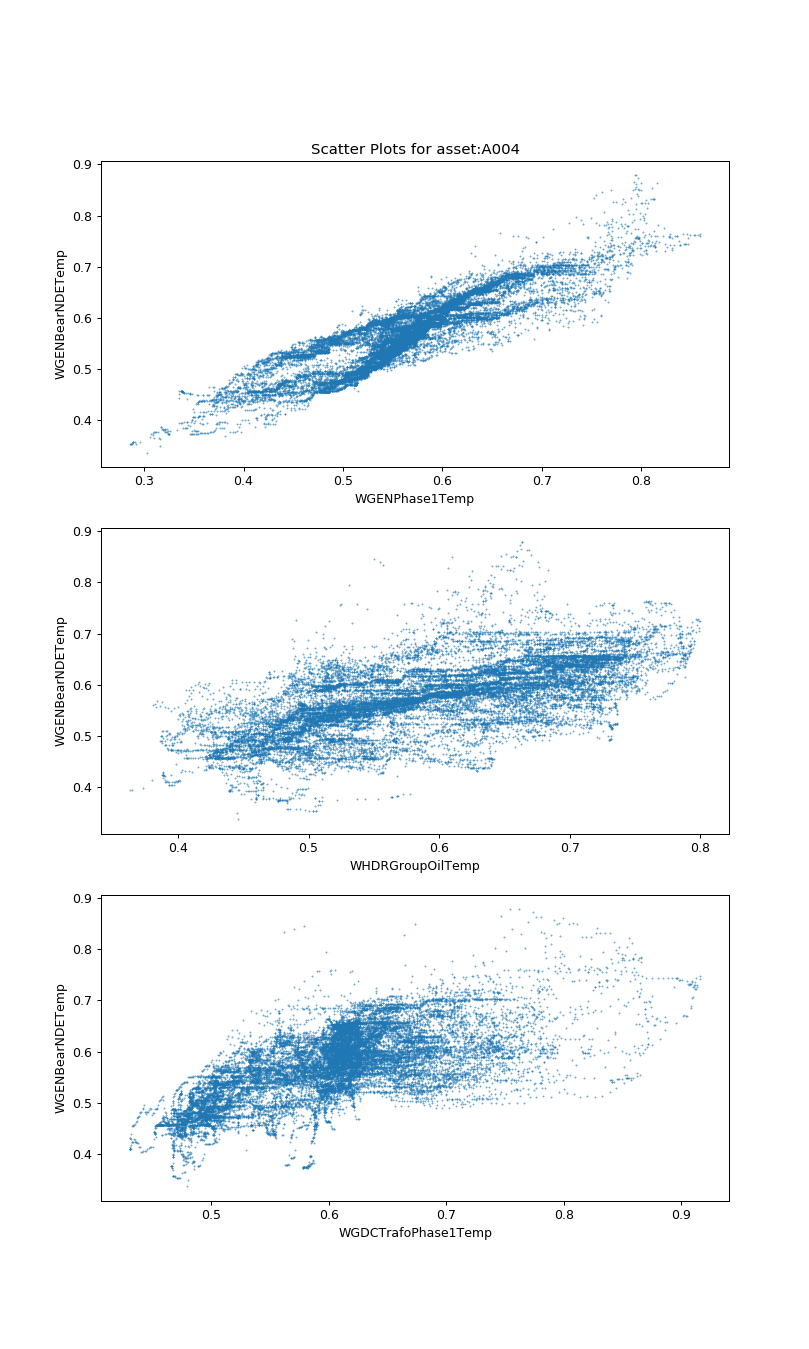

<IPython.core.display.Javascript object>


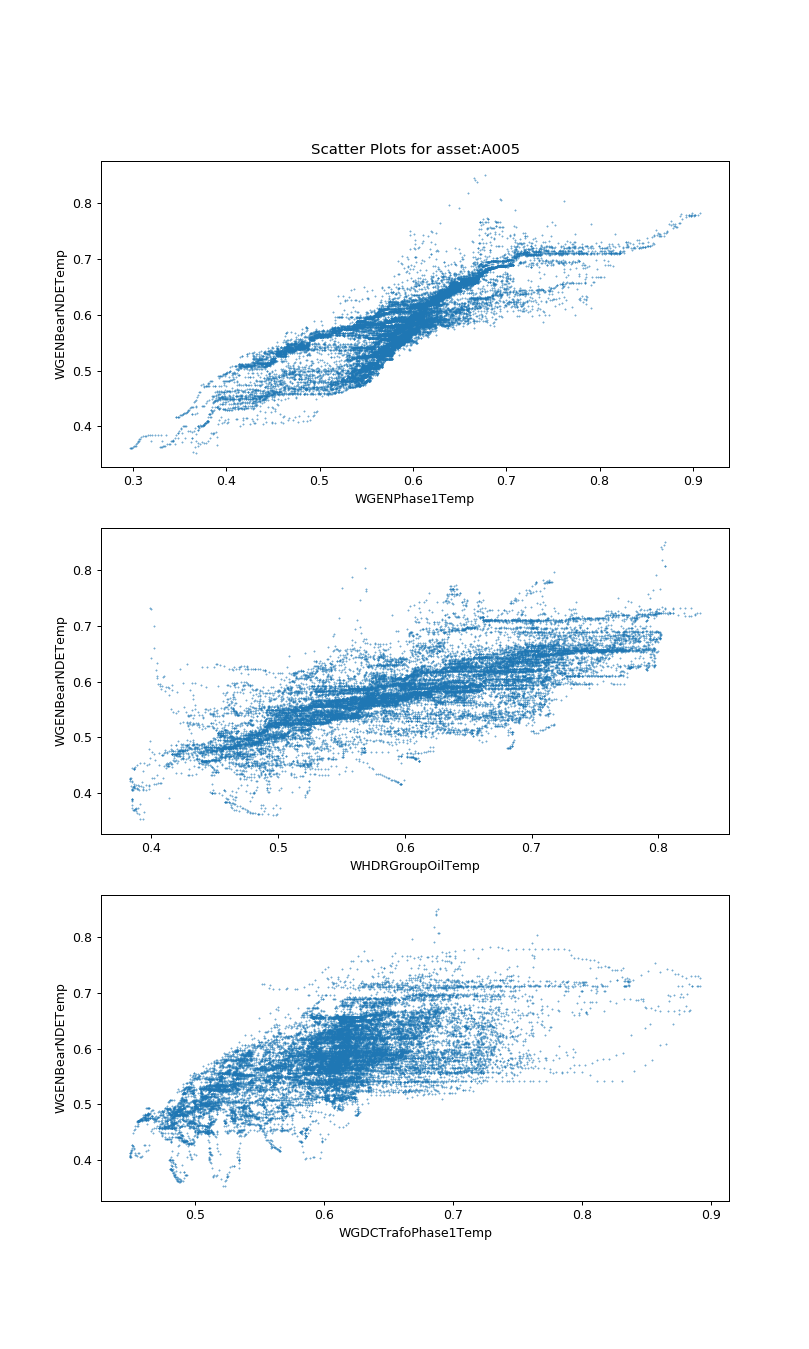

            MSE       MAE         R2
asset                               
A001   0.019984  1.042194  94.215016
A002   0.049398  1.332600  88.674290
A003   0.019507  1.009262  94.761850
A004   0.041782  1.224295  91.777673
A005   0.053870  1.357558  88.811868


In [17]:
# ********************************************* PREDICTION
args['minutal_frequency']=1
args['scatter_feature_target']=1
predict(df_hist, args)

## DATA EXPLORATION

In [11]:
def correl(df, args):
    
    target = args['target']
    # Correlation
    df_correl = df.corr(method='pearson')
    df_correl = df_correl.sort_values(target, ascending=False) 
    
    x = df_correl[target][1:]
    y = df_correl.index[df_correl.index != target]
    f, ax = plt.subplots(figsize=(10, 5))
    #sns.set_color_codes("pastel")
    sns.barplot(x=x, y=y,  label="Cor", color="g")
    # Add a legend and informative axis label
    ax.legend(ncol=1, loc="lower right", frameon=True)
    # ax.set(xlim=(0, 1), ylabel="", xlabel="correlation")
    ax.set(ylabel="", xlabel="correlation")
    sns.despine(left=True, bottom=True)

In [10]:
def distributions(df):
    
    sns.set(style='darkgrid')
    varlist = df.columns.drop(['asset'])

    fig, axs = plt.subplots(7, 4, figsize=(10, 10))
    for ax, n in zip(axs.flat, range(len(varlist))):
        subset = df[varlist[n]]
        bot = subset.min()
        top = subset.max()
        sns.violinplot(data=subset.values, ax=ax, linewidth=.8, bw=.1,
                       color=sns.hls_palette(len(varlist) + 1, l=.7, s=.5)[n])
        ax.set(xticks=(), yticks=(bot, np.mean([bot, top]), top))
        ax.set_yticklabels([np.round(bot, 2), '', np.round(top, 2)],
                           fontsize=8)
        ax.set_title(varlist[n], fontweight='bold', fontsize=9)

    sns.despine(left=True, bottom=True)
    fig.suptitle(f'Variable Distributions', fontsize=20)
    fig.tight_layout(rect=(0, 0, 1, 0.95))
    # fig.savefig('reports/distributions.png')

In [9]:
def top_correlations(df):
    
    sns.set(style='white', font_scale=.9)
    pearson = df.drop(['asset'], axis=1).corr(method='pearson')
    pairs = pearson.where(np.triu(np.ones(pearson.shape, dtype='bool'),
                                  k=1)).stack().sort_values(ascending=False)

    grid = dict(height_ratios=[1, 1]) # Changes proportion of fig.size for each subplot
    fig, axs = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw=grid)
    
    Ntop=20 # top correlation pairs
    Nbot=20 # bottom correalation pairs

    subset = pairs[pairs >= 0].head(Ntop)
    sns.barplot(x=subset.values, y=subset.index, ax=axs[0],
                palette=sns.color_palette('OrRd_r', Ntop))
    axs[0].set(xlim=(.5, 1), xticks=(),
               yticklabels=[v[0] + ' - ' + v[1] for v in subset.index])
    axs[0].set_yticklabels([v[0] + ' - ' + v[1] for v in subset.index])
    for i, corr in zip(range(len(subset)), subset.values):
        axs[0].text(corr + .01, i, round(corr, 2), va='center')

    subset = pairs[pairs < 0].tail(Nbot)
    sns.barplot(x=subset.values, y=subset.index, ax=axs[1],
                palette=sns.color_palette('PuBu', Nbot))
    axs[1].set(xlim=(-.5, -1), xticks=(),
               yticklabels=[v[0] + ' - ' + v[1] for v in subset.index])
    for i, corr in zip(range(len(subset)), subset.values):
        axs[1].text(corr - .01, i, round(corr, 2), va='center')

    sns.despine(bottom=True)
    fig.suptitle(f'Top Variable Correlation Pairs', fontsize=20)
    fig.tight_layout(rect=(0, 0, .95, .95))
    # fig.savefig('reports/top_correlations.png')

In [8]:
def correlation_matrix(df):
    
    sns.set(style='white', font_scale=.9)
    clusters = 4
    # pearson = df.drop(['asset', 'timestamp'], axis=1).corr(method='pearson')
    pearson = df.drop(['asset'], axis=1).corr(method='pearson')
    clust = SpectralCoclustering(n_clusters=clusters, random_state=0)
    clust.fit(pearson)
    pearson = pearson.iloc[np.argsort(clust.row_labels_)[::-1],
                           np.argsort(clust.column_labels_)]

    grid = dict(width_ratios=[1.5, pearson.shape[1]])
    fig, axs = plt.subplots(1, 2, figsize=(8, 8), gridspec_kw=grid)

    sns.heatmap(data=np.sort(clust.row_labels_)[::-1].reshape(-1, 1),
                ax=axs[0],
                cbar=False, linewidths=.005,
                cmap=sns.color_palette('Spectral'))
    axs[0].set(xticks=(), yticks=())

    sns.heatmap(data=pearson,
                cmap=sns.diverging_palette(220, 10, n=11),
                linewidths=.005,
                cbar_kws={'shrink': .75}, vmax=1, vmin=-1,
                ax=axs[1])
    axs[1].set_xticklabels(pearson.columns, rotation='vertical')
    axs[1].set_yticklabels(pearson.index, rotation='horizontal')

    fig.suptitle(f'Variable Correlation Matrix in {clusters} Clusters',
                 fontsize=20)
    fig.tight_layout(w_pad=.5, rect=(.03, 0, 1, .95))
    fig.show()
    # fig.savefig('reports/correlation_matrix.png')

In [7]:
def feature_pre_selection(df_hist, args):
    
    target = args['target']
    list_a = list(df_hist.columns)
    
    # List of features discarded by correlation inspection
    list_b = ['timestamp', 'asset', target,
              'WGDCTrafoPhase2Temp','WGDCTrafoPhase3Temp',
              'WGENPhase2Temp', 'WGENPhase3Temp',
              'WROTPitchAngleSP',
              'WNACAmbTemp',
              'WGENBearDETemp',
              'WNACWindSpeed',
             ]
    
    '''      features pending inspection:
              'WCNVCosPhi', 'WCNVNetVoltage',  
              'WGENGenSpeed',
              'WHDRGroupOilPress','WHDRGroupOilTemp', 
              'WNACDirection', 'WNACWindDirection',
              'WROTSpeed', 
              'WTRMBearTemp','WTRMOilTemp', 
              'WTURPowerAux', 'WTURReactivePower', 'WTURReactivePowerAux',
              'WYAWPressure'
    '''
    # sselected features for modeling
    features = [item for item in list_a if item not in list_b]
    
    return features

## FEATURE SELECTION

In [6]:
def univariate_select(df_hist, args):
    # Feature Extraction with Univariate Statistical Tests 
    # Chi-squared for classification or F1 for regression

    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import mutual_info_regression
    
    target = args['target']
    features = feature_pre_selection(df_hist, args)
    
    y_data = df_hist[ target ]
    x_data = df_hist[ features ]

    # feature extraction
    kbest = SelectKBest(score_func=mutual_info_regression)
    fit = kbest.fit(x_data, y_data)

    # summarize scores
    df_out = pd.DataFrame(fit.scores_,index=x_data.columns,columns=['scores'])
    df_out = df_out.sort_values('scores', ascending=False) 
    
    np.set_printoptions(precision=2)
    # print(fit.scores_)

    print('Results:')
    print(df_out)

In [5]:
def rfe(df_hist, args):
    '''recursive feature extraction'''

    from sklearn.feature_selection import RFE

    target = args['target']
    features = feature_pre_selection(df_hist, args)
    
    # feature extraction
    model = RandomForestRegressor(max_depth=9,random_state=0)
    rfe = RFE(model, 5)    

    # Data definition for ML training
    y_data = df_hist[ target ]
    x_data = df_hist[ features]
    fit = rfe.fit(x_data, y_data)

    model.fit(x_data, y_data)

    df_out = pd.DataFrame(model.feature_importances_,index=x_data.columns,columns=['importances'])
    df_out['ranking'] = fit.ranking_         
    df_out['support'] = fit.support_ 
    df_out = df_out.sort_values('importances', ascending=False) 

    #print("Num Features: {}".format(fit.n_features_))
    #print("Selected Features: {}".format(fit.support_))
    #print("Feature Ranking: {}".format(fit.ranking_))

    print('Results:')
    print(df_out)
        

## PREDICTION

In [4]:
def predict(df_hist, args):
    ''' Data Modeling '''

    # Define features for model training and target label
 
    #features = ['WGDCTrafoPhase1Temp', 'WNACNacelleTemp', 'WTURPower']
    features = ['WGENPhase1Temp', 'WHDRGroupOilTemp', 'WGDCTrafoPhase1Temp'] 
    feature1 = features[0]
    feature2 = features[1]
    feature3 = features[2]
    
    target = args['target']
    
    # Loop over assets
    df_metrics = pd.DataFrame()
    assets = df_hist.asset.unique()
    for i, asset in enumerate(assets[:]):
        asset_mask = df_hist.asset==asset

        # Data definition for ML training
        y_data = df_hist.loc[asset_mask, target]
        x_data = df_hist.loc[asset_mask, features]
        x_train, x_test, y_train, y_test, model = ML_model(x_data,y_data) #FUN Call
        model.fit(x_train, y_train)

        #*******************
        # MLModel metrics    
        model_score = model.score(x_test,y_test)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)*100
        mae = mean_absolute_error(y_test,y_pred)*100
        r2  = r2_score(y_test, y_pred)*100      

        # Build dataframe with predicted values. Used for visualization
            
        if i == 0:
            df_plot = x_data.copy()
            df_plot['asset']=asset
            df_plot[target]=y_data
            df_plot['prediction'] = model.predict(x_data)
        else:
            df_concat = x_data.copy()
            df_concat['asset']=asset
            df_concat[target] = y_data
            df_concat['prediction'] = model.predict(x_data)    
            df_plot = pd.concat([df_plot, df_concat], axis=0)    

        # SHOWN TEST SCORES **************************************************
        if 1: # add args parameter to control show/no-show
            if i==0: print('Machine Learing model score wiht historical scada')
            new_row = pd.DataFrame([[asset, mse, mae, r2]],
                                   columns=['asset', 'MSE', 'MAE', 'R2'])
            df_metrics = pd.concat([df_metrics, new_row])

        #*************************************************************
        # PLOTS
        
        # Time Series for Y_pred
        if args['target_time_series']:
            mystyle()
            dfA = df_hist[df_hist.asset == asset]
            dfB = df_plot[df_plot.asset == asset]

            fig, ax1 = plt.subplots( figsize=(9,4) )
            dfA[target].plot(ax=ax1, lw=.5)
            #dfB['prediction'].plot(style='g.-', lw=0, ax=ax1)
            dfB['prediction'].plot(lw=.1, ax=ax1)
            ax1.set_title('Historical records for asset: '+ asset)
            ax1.set_ylabel(target)
            ax1.set_xlabel('month-day')       
                  
        # Scatter-Plots PREDICTED 
        
        if args['scatter_feature_target']:   
            dfA = df_plot[df_plot.asset==asset]
            fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9,15) )
            
            dfA.plot.scatter(feature1, 'prediction', ax=ax1, marker='.', s=.5)
            dfA.plot.scatter(feature2, 'prediction', ax=ax2, marker='.', s=.5)
            dfA.plot.scatter(feature3, 'prediction', ax=ax3, marker='.', s=.5)
            
            ax1.set_title('Scatter Plots for asset:'+ asset)
            
            ax1.set_ylabel(target)
            ax2.set_ylabel(target)
            ax3.set_ylabel(target)
            
            ax1.set_xlabel(feature1)
            ax2.set_xlabel(feature2)
            ax3.set_xlabel(feature3)   
            
    df_metrics.set_index('asset', inplace=True)        
    print(df_metrics)
    
    return 

## ML FUNCTIONS

In [3]:
def ML_model(x_data, y_data):
    ''' Machine Learning Model Definition '''
    
    from sklearn.model_selection import train_test_split
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=.3, random_state=0) 
    
    selector = 3
    
    if selector == 1:
        model = DecisionTreeRegressor(max_depth=7, random_state=0, splitter='best')
        
    elif selector == 2:
        model = GradientBoostingRegressor(n_estimators=100,  learning_rate=0.1, 
                                          max_depth=7, random_state=0, loss='ls')
    elif selector==3:    
        model = RandomForestRegressor(max_depth=9,random_state=0)
        
    return x_train, x_test, y_train, y_test, model      

## READ CSV FILES

In [2]:
def read_historical_scada(options):
    '''select and read 1, 2, or 10 minutal SCADA datasets to train ML model'''
    
    cwd = r'I:\home'
    
    frequency = options['minutal_frequency']
    in_path = os.path.join(cwd,'data')
    
    if frequency == 10:
        file_ext =  '-10m.csv'
        
    elif frequency == 2:
        file_ext =  '-2m.csv'
        
    elif frequency == 1:
        file_ext =  '-1m.csv'       

    
    months = ['04','05','06','07','08']
    for i, month in enumerate (months):
        in_file = '2015-'+ month + file_ext        
        in_csv = os.path.join(in_path, in_file)
        if i==0:           
            df = pd.read_csv(in_csv)
        else:
            df_cat = pd.read_csv(in_csv)
            df = pd.concat([df, df_cat], axis=0)
            
    df = df.dropna(axis=0)    
    #df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    #df.set_index('datetime', inplace=True)
    df.set_index('timestamp', inplace=True)
    
    return df  

In [1]:
def mystyle():
    '''set some default parameters for visualizations'''
    
    plt.style.use('seaborn-white')
    plt.rcParams ['axes.grid']=False 
    plt.rcParams ['axes.spines.left']   = True   # display axis spines
    plt.rcParams ['axes.spines.bottom'] = True
    plt.rcParams ['axes.spines.top']    = False
    plt.rcParams ['axes.spines.right']  = False 

In [4]:
def rfe_per_asset(df_hist, args):
    '''recursive feature extraction'''

    from sklearn.feature_selection import RFE

    target = args['target']
    features = feature_pre_selection(df_hist, args)
    
    # feature extraction
    model = RandomForestRegressor(max_depth=9,random_state=0)
    rfe = RFE(model, 5)    

    # Loop over assets
    assets = df_hist.asset.unique()
    for i, asset in enumerate(assets[:1]):
        asset_mask = df_hist.asset==asset

        # Data definition for ML training
        y_data = df_hist.loc[asset_mask, target ]
        x_data = df_hist.loc[asset_mask, features]
        fit = rfe.fit(x_data, y_data)
        
        model.fit(x_data, y_data)
        
        df_out = pd.DataFrame(model.feature_importances_,index=x_data.columns,columns=['importances'])
        df_out['ranking'] = fit.ranking_         
        df_out['support'] = fit.support_ 
        df_out = df_out.sort_values('importances', ascending=False) 

        #print("Num Features: {}".format(fit.n_features_))
        #print("Selected Features: {}".format(fit.support_))
        #print("Feature Ranking: {}".format(fit.ranking_))
        
        print('Results:')
        print(df_out)